# UCI heart disease analysis 
_By Tom Talpir (OpenU - Prolog course)_
<br>
This notebook is for cleaning & analyzing the raw data before it'll be ingested into Prolog.

The Prolog Expert system will be built with a decision tree and some manual IF/ELSE rules, so we'll perform some 
exploratory data analysis.

### The data
I'm using the UCI heart disease data. More info can be found on Kaggle (https://www.kaggle.com/ronitf/heart-disease-uci) and on the UCI website (https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

### Goal
We're trying to predict whether there's a heart condition or not (0=no, 1=yes)

#### Disclaimer
Since this is a toy example, there are many features in the original dataset that require cardiological understanding.
To make the expert system easy to use, we'll drop the ones that aren't easy to understand or answer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('./raw_heart_data.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#### Transform numeric age to categories

In [4]:
df['age_category'] = pd.cut(df.age, bins=[0,18,35,50,65, 120], labels=['child', 'young_adult', 'middle_age', 'adult', 'senior'])

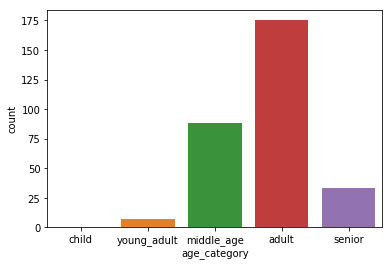

In [5]:
sns.countplot(x='age_category', data=df)

#### Gender from numeric to category

In [21]:
df['gender'] = df['sex'].apply(lambda x: 'male' if x == 1 else 'female')

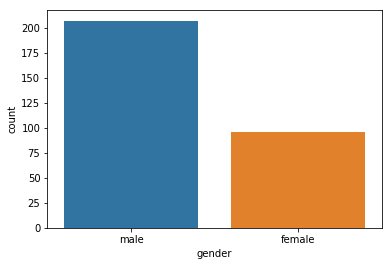

In [22]:
sns.countplot(x='gender', data=df)

#### Resting blood preasure
We'll divide the values into bins - low, medium, high. Let's see the mean values & percentiles to figure the numbers for the categories

In [15]:
df['trestbps'].describe()

count    303.000000
mean     131.623762
std       17.538143
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

In [16]:
df['resting_bp'] = pd.cut(df.trestbps, bins=[0,120,140, 200], labels=['low', 'normal', 'high'])

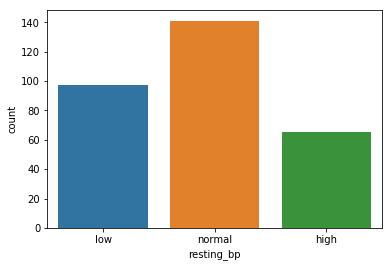

In [17]:
sns.countplot(x='resting_bp', data=df)

#### Cholesterol levels
Just like we did for resting blood preasure

In [18]:
df['chol'].describe()

count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64

In [19]:
df['cholesterol'] = pd.cut(df.chol, bins=[0,211,274, 600], labels=['low', 'normal', 'high'])

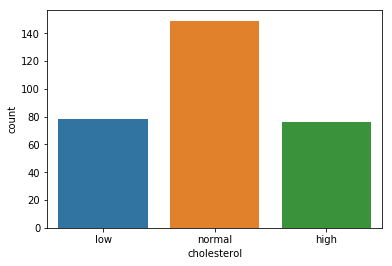

In [20]:
sns.countplot(x='cholesterol', data=df)

#### Blood sugar levels
Numeric to categorical

In [24]:
df['blood_sugar'] = df['fbs'].apply(lambda x: 'high' if x == 1 else 'low')

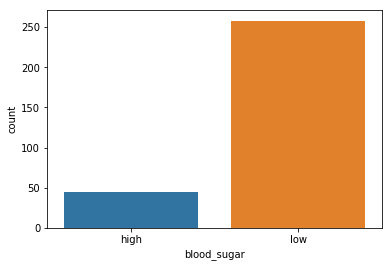

In [25]:
sns.countplot(x='blood_sugar', data=df)

#### Chest pain during exercise 
Not exactly what this feature means, but doing the best we can :)

In [55]:
df['chest_pain_only_exercise'] = df['exang'].apply(lambda x: 'yes' if x == 1 else 'no')

#### Max difficulty reached during treadmil test

In [62]:
def get_max_treadmil_difficulty(max_slope_level):
    if max_slope_level == 2:
        return 'easy'
    elif max_slope_level == 1:
        return 'medium'
    return 'hard'
df['max_treadmil_dificulty'] = df['slope'].apply(get_max_treadmil_difficulty)

#### Looks like these are enough variables! 
Let's copy them into a new df which will be our final df, and look for some correlations

In [65]:
final_df = df[['age_category', 'gender', 'resting_bp', 'cholesterol', 'blood_sugar', 'chest_pain_only_exercise', 'max_treadmil_dificulty', 'target']].copy()

In [66]:
final_df.head()

,age_category,gender,resting_bp,cholesterol,blood_sugar,chest_pain_only_exercise,max_treadmil_dificulty,target
0,adult,male,high,normal,high,no,hard,1
1,middle_age,male,normal,normal,low,no,hard,1
2,middle_age,female,normal,low,low,no,easy,1
3,adult,male,low,normal,low,no,easy,1
4,adult,female,low,high,low,yes,easy,1


### Max treadmil difficulty

People w/o a heart condition

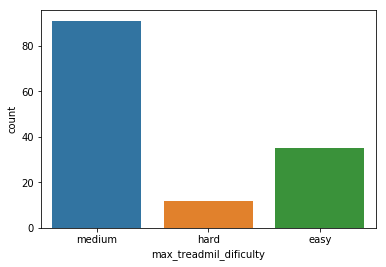

In [75]:
sns.countplot(x='max_treadmil_dificulty', data=df[df['target'] == 0])

People with a heart condition

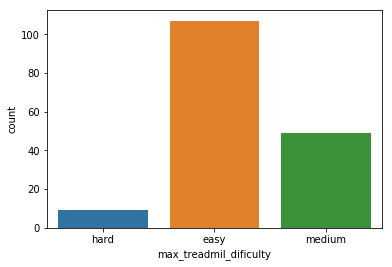

In [76]:
sns.countplot(x='max_treadmil_dificulty', data=df[df['target'] == 1])

#### This is a strong feature!
We can clearly see that the majority of people with a heart condition only reach the "easy" level on the treadmil for the ECG test, while ones without a heart condition are mostly on medium

### Chest pain only during exercise
Does the patient only report chest pain during exercise?

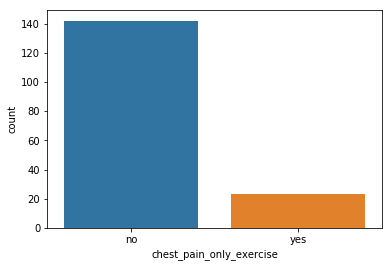

In [77]:
sns.countplot(x='chest_pain_only_exercise', data=df[df['target'] == 1])

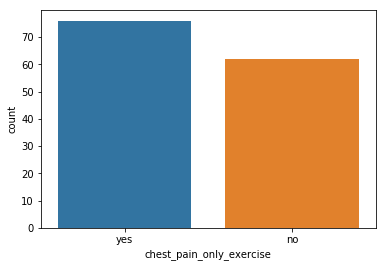

In [78]:
sns.countplot(x='chest_pain_only_exercise', data=df[df['target'] == 0])

**This is another good indication!**
<br>
When answering the question - "Is there chest pain only during exercise?" we can see that patients with a heart condition tend to have chest pain always, regardless of exercise. The ones without tend to be 50/50.
<br>
This means that chest pain **not only while exercising** is highly correlated with having a heart condition

### The rest of the features
Surprisingly, there's very little correlation between age, resting blood pressure, cholesterole and so on.
We can see this with a pairplot (running this on the original values which are numeric, and not our new categorical values)

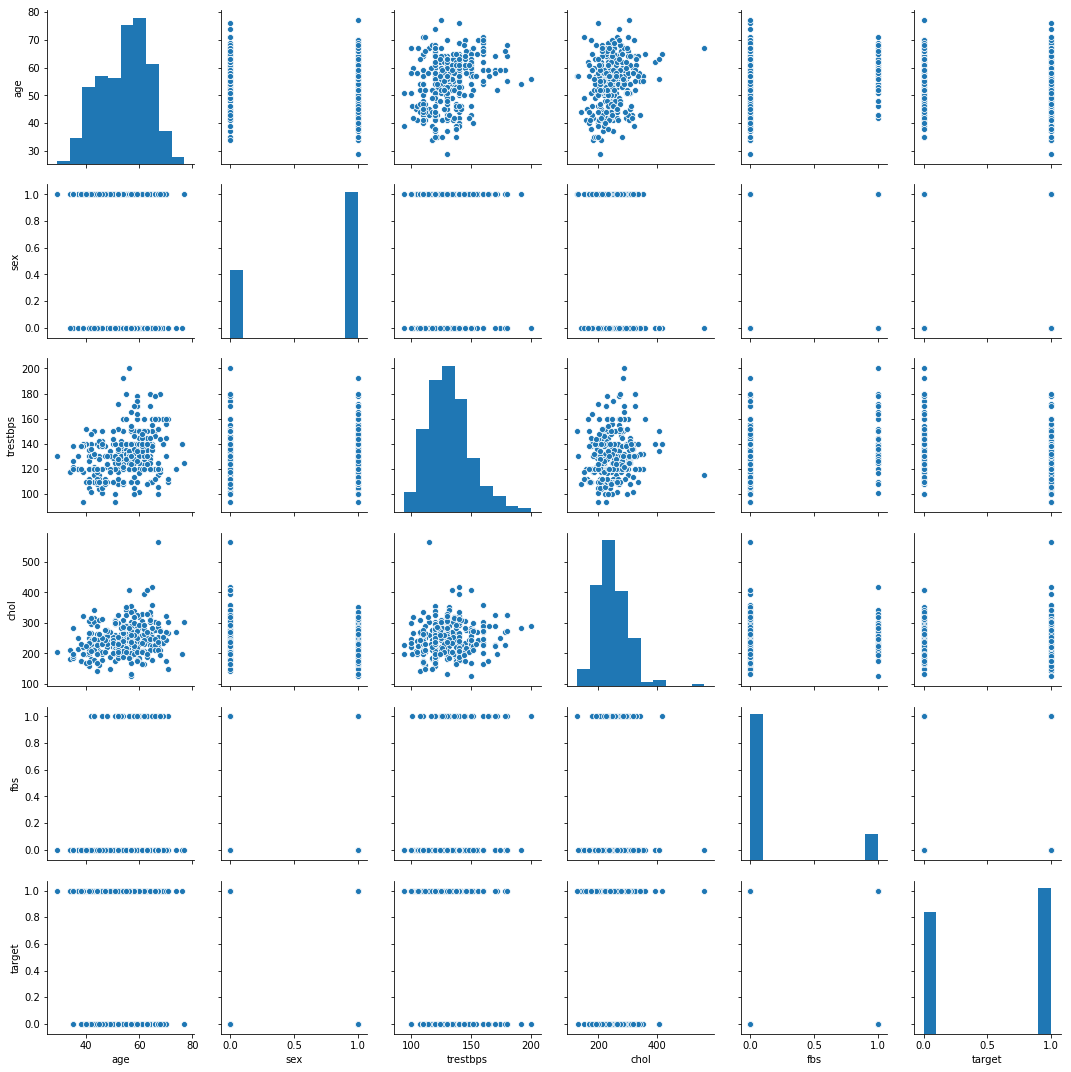

In [80]:
sns.pairplot(df[['age', 'sex', 'trestbps', 'chol', 'fbs', 'target']])

As we can see, very little correlation between the target value and the others...

## Exporting the data as a new CSV file, which will be parsed by Prolog

In [83]:
final_df.to_csv('./parsed_data.csv', header=False, )